In [1]:
import pickle
import hist

import matplotlib
%matplotlib inline
import mplhep
matplotlib.style.use(mplhep.style.ROOT)
import matplotlib.pyplot as plt

In [32]:
with open('full-mc-bkgd-single-signal.pkl','rb') as f:
    hdf = pickle.load(f)

In [33]:
hdf

{'wab': {'nvtxs': Hist(Regular(4, 0, 4, name='nvtxs', label='N Vertices'), storage=Double()) # Sum: 1220835.0,
  'vtxz': Hist(Regular(40, -5, 195, name='vtxz', label='Vertex Z [mm]'), storage=Double()) # Sum: 37637.0 (59586.0 with flow)},
 'tritrig': {'nvtxs': Hist(Regular(4, 0, 4, name='nvtxs', label='N Vertices'), storage=Double()) # Sum: 10383743.0 (10383746.0 with flow),
  'vtxz': Hist(Regular(40, -5, 195, name='vtxz', label='Vertex Z [mm]'), storage=Double()) # Sum: 4690569.0 (7339409.0 with flow)},
 'rmap-3.00-rdmchi-0.60-mchi-030': {'nvtxs': Hist(Regular(4, 0, 4, name='nvtxs', label='N Vertices'), storage=Double()) # Sum: 4348.0,
  'vtxz': Hist(Regular(40, -5, 195, name='vtxz', label='Vertex Z [mm]'), storage=Double()) # Sum: 2381.0 (3232.0 with flow)}}

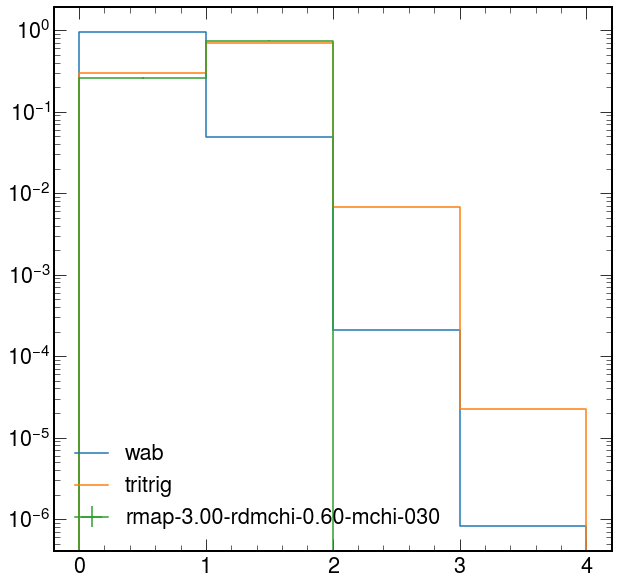

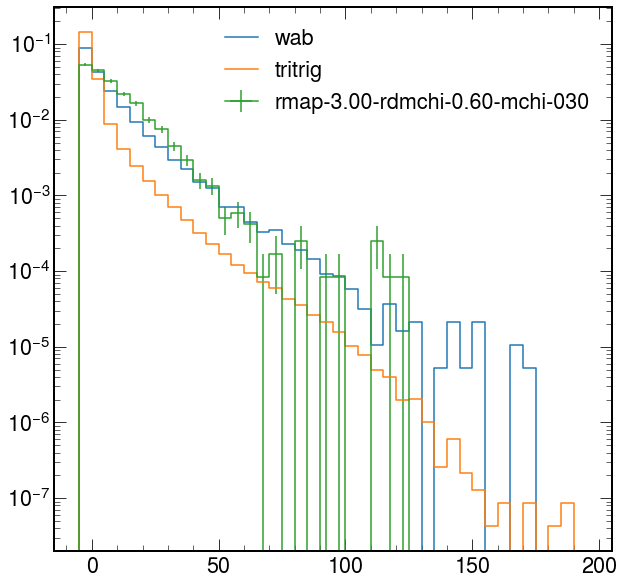

In [34]:
for sample, hists in hdf.items():
    hists['nvtxs'].plot(label=sample, density=True)
plt.yscale('log')
plt.legend()
plt.show()

for sample, hists in hdf.items():
    hists['vtxz'].plot(label=sample, density=True)
plt.yscale('log')
plt.legend()
plt.show()

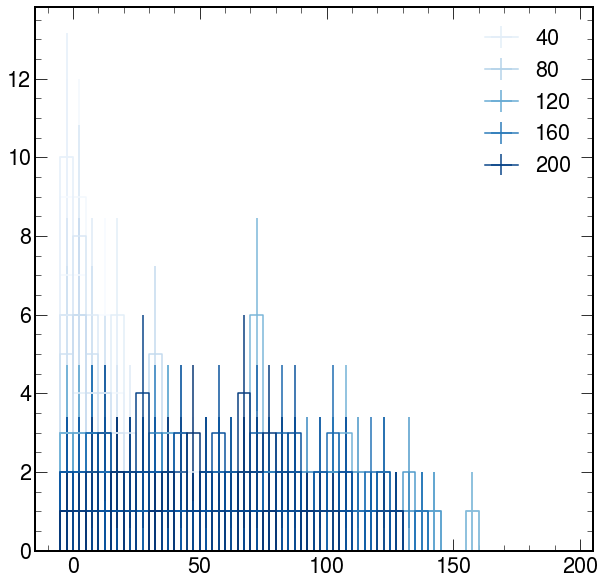

In [20]:
from cycler import cycler
from collections import OrderedDict
fig, ax = plt.subplots()
nlines = len(hdf['rmap-3.00-rdmchi-0.60'])
ax.set_prop_cycle(
    cycler(
        'color',
        [
            matplotlib.cm.get_cmap('Blues')(i/nlines) 
            for i in range(nlines)
        ]
    )
)
for mchi, histograms in OrderedDict(sorted(hdf['rmap-3.00-rdmchi-0.60'].items())).items():
    histograms['vtxz'].plot(
        ax=ax, 
        label=mchi if mchi%40==0 else '_no_legend'
    )
plt.legend()
plt.show()

In [25]:
import pandas as pd
import numpy as np

In [37]:
import pandas as pd
import uproot
import awkward as ak
import numpy as np

lumi = 10.7 # pb^{-1}
inverse_alpha = 137

def radFrac(mass):
    """total radiative fraction polynomial fit to MC distributions

    calculated by Alic Spellman for 2016 SIMPs using KF tracking on 11/15/22
    """
    radF = -1.04206e-01 \
         + 9.92547e-03*mass \
         + -1.99437e-04*pow(mass, 2) \
         + 1.83534e-06*pow(mass, 3) \
         + -7.93138e-9*pow(mass, 4) \
         + 1.30456e-11*pow(mass, 5)
    return radF

def totRadAcc(mass):
    """Total radiative acceptance polynomial fit to MC distributions

    calculated by Alic Spellman for 2016 SIMPs using KF tracking on 11/15/22
    """
    acc = -7.35934e-01 \
        + 9.75402e-02*mass \
        - 5.22599e-03*pow(mass, 2) \
        + 1.47226e-04*pow(mass, 3) \
        - 2.41435e-06*pow(mass, 4) \
        + 2.45015e-08*pow(mass, 5) \
        - 1.56938e-10*pow(mass, 6) \
        + 6.19494e-13*pow(mass, 7) \
        - 1.37780e-15*pow(mass, 8) \
        + 1.32155e-18*pow(mass, 9)
    return acc

def dNdm(mass, binwidth = 30.0):
    value = 0.0
    for name, pack in dNdm.__raw_data.items():
        t = pack['tree']
        value += ak.sum(
            (t['unc_vtx_mass']*1000 > mass - binwidth/2)&(t['unc_vtx_mass']*1000 < mass + binwidth/2)
        )*pack['scale']
    return value/binwidth

dNdm.__raw_data = {
    'tritrig': {
        'file': '../../simp-rate/final_hadd_tritrigv2-beamv6_2500kBunches_HPS-PhysicsRun2016-Pass2_v4_5_0_pairs1_976_KF_CR.root',
        'scale': 1.416e9*lumi/(50000*9853)
    },
    'wab': {
        'file': '../../simp-rate/final_hadd_wabv3-beamv6_2500kBunches_HPS-PhysicsRun2016-Pass2_v4_5_0_pairs1_KF_ana_CR.root',
        'scale': 0.1985e12*lumi/(100000*9966)
    }
}

for name, pack in dNdm.__raw_data.items():
    with uproot.open(pack['file']) as f:
        pack['tree'] = f['vtxana_kf_vertexSelection_Tight_CR/vtxana_kf_vertexSelection_Tight_CR_tree'].arrays()

def darkphoton_production(mass):
    if totRadAcc(mass) > 0:
        return (3*inverse_alpha/2)*np.pi*mass*radFrac(mass)*dNdm(mass)/totRadAcc(mass)
    else:
        return 0

In [39]:
df = pd.DataFrame({
    'mchi' : np.zeros(len(hdf['rmap-3.00-rdmchi-0.60'])),
    'npass' : np.zeros(len(hdf['rmap-3.00-rdmchi-0.60'])),
    'prod' : np.zeros(len(hdf['rmap-3.00-rdmchi-0.60']))
})
for i, (mchi, histos) in enumerate(hdf['rmap-3.00-rdmchi-0.60'].items()):
    npass = histos['vtxz'][20j:].sum()
    prod = darkphoton_production(3*mchi)
    df.iloc[i] = (mchi, npass, prod)
df['rmap'] = 3.00
df['rdmchi'] = 0.60
df['nthrown'] = 10*10000
df['frac'] = df.npass/df.nthrown
df['acc'] = df['prod']*df.frac
df.sort_values('mchi')

,mchi,npass,prod,rmap,rdmchi,nthrown,frac,acc
1,20.0,5.0,4.464022e+10,3.0,0.6,100000,0.00005,2.232011e+06
18,25.0,7.0,2.760450e+10,3.0,0.6,100000,0.00007,1.932315e+06
37,30.0,5.0,1.784341e+10,3.0,0.6,100000,0.00005,8.921703e+05
8,35.0,9.0,1.176885e+10,3.0,0.6,100000,0.00009,1.059197e+06
27,40.0,7.0,7.876023e+09,3.0,0.6,100000,0.00007,5.513216e+05
25,45.0,5.0,5.618033e+09,3.0,0.6,100000,0.00005,2.809017e+05
10,50.0,3.0,4.154253e+09,3.0,0.6,100000,0.00003,1.246276e+05
22,55.0,7.0,3.012514e+09,3.0,0.6,100000,0.00007,2.108760e+05
23,60.0,7.0,2.064559e+09,3.0,0.6,100000,0.00007,1.445191e+05
19,65.0,7.0,1.952762e+09,3.0,0.6,100000,0.00007,1.366933e+05


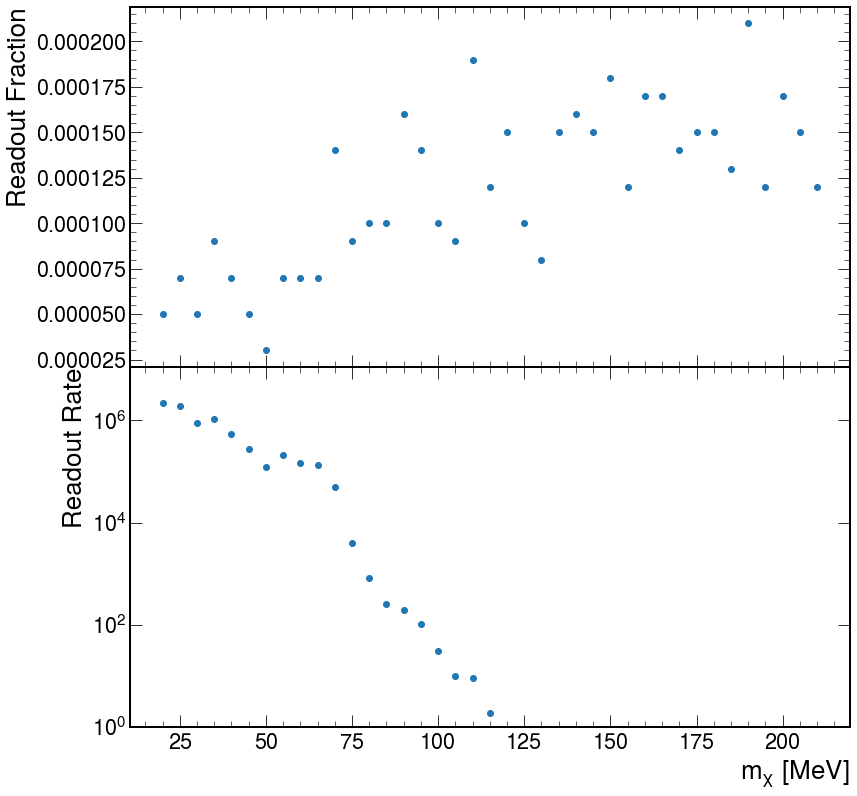

In [47]:
fig, (frac, rate) = plt.subplots(
    nrows = 2,
    sharex = True,
    gridspec_kw = dict(
        hspace = 0,
        bottom = 0,
        top = 1,
        left = 0,
        right = 1
    )
)

frac.scatter(
    df.mchi,
    df.frac
)
#frac.set_yscale('log')
frac.set_ylabel('Readout Fraction')
rate.scatter(
    df.mchi,
    df.acc
)
rate.set_yscale('log')
rate.set_ylim(ymin=1)
rate.set_ylabel('Readout Rate')
rate.set_xlabel('$m_\\chi$ [MeV]')

plt.show()